<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download preprocessed dataset
!wget -qO ratings_M50-MF10.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ERH77foX8FJHmpPoczPf4-UBxHLwVZh-qobnU9uQvGuguw?download=1

In [2]:
import torch
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 4)

In [3]:
# read dataset into dataframe

df = pd.read_pickle('ratings_M50-MF10.dfpkl')
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 111 num_movie: 50


,user,movie,rating
0,0,0,4.0
1,0,7,5.0
...,...,...,...
1616,110,44,4.0
1617,110,46,3.0


In [4]:
# split data into train and test sets

split = 0.8
train = df.sample(frac=split)
test  = df[~df.index.isin(train.index)]

display(train)
display(test)

,user,movie,rating
658,36,26,1.0
72,5,45,5.0
...,...,...,...
182,11,47,5.0
1149,71,18,2.0


,user,movie,rating
7,0,34,1.0
12,1,2,3.0
...,...,...,...
1612,110,26,4.0
1617,110,46,3.0


In [5]:
# build the matrix-multiplication-based model

class UV(nn.Module):
    def __init__(self, N, M, D):       # N: num_user, M: num_movie, D: embedding dimension
        super().__init__()
        self.U = nn.Embedding(N, D)    # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(M, D)    # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, u_idx, m_idx):
        U = self.U(u_idx)                  # retrieve user embeddings by user indexes
        V = self.V(m_idx)                  # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)    # predicted ratings are their dot products
        return dot_products

In [6]:
###
# training
###

# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
max_epoch = 9999

# initialize model and ...
model = UV(N, M, D)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# convert data to torch Tensor
train_u_idx = torch.IntTensor  (train.user.values)
train_v_idx = torch.IntTensor  (train.movie.values)
train_y     = torch.FloatTensor(train.rating.values)

test_u_idx  = torch.IntTensor  (test.user.values)
test_v_idx  = torch.IntTensor  (test.movie.values)
test_y      = torch.FloatTensor(test.rating.values)

# train
recs = []
for epoch in range(max_epoch):

    # gradient descent
    model.train()
    optimizer.zero_grad()

    train_y_hat = model(train_u_idx, train_v_idx)
    loss = loss_fn(train_y_hat, train_y)
    loss.backward()
    optimizer.step()

    # evaluate test loss
    model.eval()
    test_y_hat = model(test_u_idx, test_v_idx)
    test_loss = loss_fn(test_y_hat, test_y)
    rec = {
        'epoch'     : epoch,
        'train_loss': loss.item(),
        'test_loss' : test_loss.item(),
    }
    recs.append(rec)

    if epoch % 100 == 0:
        print(rec)

{'epoch': 0, 'train_loss': 19.57349967956543, 'test_loss': 17.206912994384766}
{'epoch': 100, 'train_loss': 17.403663635253906, 'test_loss': 16.09406852722168}
{'epoch': 200, 'train_loss': 15.58791732788086, 'test_loss': 15.19824504852295}
{'epoch': 300, 'train_loss': 14.178954124450684, 'test_loss': 14.526213645935059}
{'epoch': 400, 'train_loss': 13.051407814025879, 'test_loss': 14.007922172546387}
{'epoch': 500, 'train_loss': 12.124448776245117, 'test_loss': 13.597648620605469}
{'epoch': 600, 'train_loss': 11.34373664855957, 'test_loss': 13.264269828796387}
{'epoch': 700, 'train_loss': 10.671481132507324, 'test_loss': 12.985834121704102}
{'epoch': 800, 'train_loss': 10.080662727355957, 'test_loss': 12.746345520019531}
{'epoch': 900, 'train_loss': 9.551538467407227, 'test_loss': 12.53384780883789}
{'epoch': 1000, 'train_loss': 9.069439888000488, 'test_loss': 12.339184761047363}
{'epoch': 1100, 'train_loss': 8.623363494873047, 'test_loss': 12.155227661132812}
{'epoch': 1200, 'train_lo

<Axes: xlabel='epoch'>

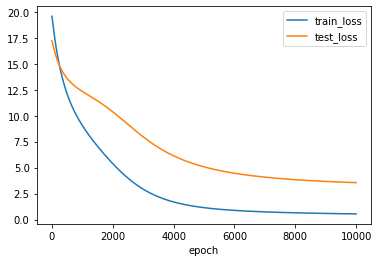

In [7]:
# training curves
pd.DataFrame(recs).set_index('epoch')[['train_loss', 'test_loss']].plot()

In [8]:
# resulted U and V
U = model.U.weight
V = model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[-1.3004,  0.3857,  0.7459, -0.3573,  1.2101,  0.1454,  0.3544, -0.1769,
         -1.4641, -2.0547],
        [ 0.2070, -0.5764, -2.0226,  0.3139,  1.3664,  0.8648,  0.8995, -0.2002,
          0.4597,  0.2427],
        [-0.2643,  1.7638,  1.5605,  0.5999,  0.3925,  0.8460,  1.3910, -0.5764,
         -0.8385, -0.6982]], grad_fn=<SliceBackward0>)
V: tensor([[-0.0525, -0.9252,  0.3766,  2.1550,  2.0828, -0.1178,  0.2866, -0.3241,
         -1.3796,  0.2322],
        [ 0.7697,  0.7317,  1.0644,  1.8774, -0.2020,  1.4141, -0.1824,  0.5441,
          0.3950,  1.2048],
        [-1.2411, -0.1996, -0.5467,  1.7134,  0.5500, -0.1541, -0.2979,  0.3038,
          0.6246, -0.7410]], grad_fn=<SliceBackward0>)


In [16]:
# prediction results

test_y_hat = model(test_u_idx, test_v_idx).detach().numpy()

df_res = (
    test
    .assign(prediction=test_y_hat,                        # raw predictions
            clipped   =test_y_hat.clip(1,5),              # clipped between 1 and 5
            residual  =lambda x: x.rating - x.clipped)
)

df_res.sample(10)

,user,movie,rating,prediction,clipped,residual
1181,73,29,4.0,4.023470,4.023470,-0.023470
388,23,35,1.0,1.651458,1.651458,-0.651458
882,51,27,3.0,3.620177,3.620177,-0.620177
102,7,16,1.0,1.373160,1.373160,-0.373160
904,53,16,2.0,2.376903,2.376903,-0.376903
591,32,42,2.0,4.323535,4.323535,-2.323535
1221,76,35,3.0,-2.149443,1.000000,2.000000
147,9,0,4.0,0.996817,1.000000,3.000000
1444,95,24,4.0,2.607067,2.607067,1.392933
1394,91,11,3.0,1.577433,1.577433,1.422567


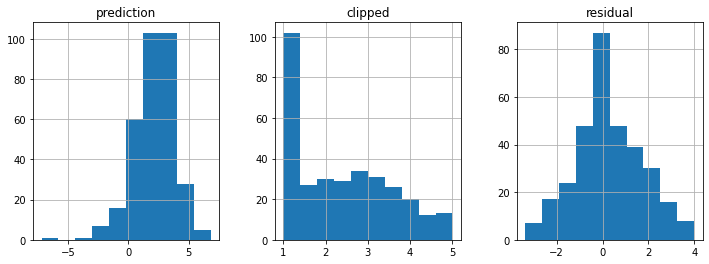

In [18]:
# distribution of residuals
df_res[['prediction', 'clipped', 'residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()